## Урок 7. Домашнее задание

In [1]:
import numpy as np
import pandas as pd
import shap

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
                            classification_report, precision_recall_curve, confusion_matrix


shap.initjs()

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Воспользуемся для анализа датасетом "Online Shoppers Purchasing Intention Dataset Data Set" (https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset), который содержит информацию о онлайн поведении пользователей и о том, произошла ли покупка по итогам посещения онлайн-магазина.

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Отметим, что присутствуют как вещественные, так и категориальные признаки. Переведем целевую переменную, которая показывает произошла ли покупка, в числовой формат.

In [3]:
df['Revenue'] = np.where(df['Revenue'] == False, 0, 1)
df['Revenue'].value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering

Разделим выборку на обучающую и тестовую для дальнейшей работы.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Revenue'], random_state=42)

Создадим новые признаки `TotalPages` и `TotalDuration`, которые будут учитывать общее количество страниц, которые посетил пользователь за анализируемый период, и суммарное время, проведенное на них.

In [5]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_mod = X.copy()
        X_mod.loc[:, 'TotalPages'] = X.loc[:, 'Administrative'] + X.loc[:, 'Informational']\
                                    + X.loc[:, 'ProductRelated']
        X_mod.loc[:, 'TotalDuration'] = X.loc[:, 'Administrative_Duration'] + X.loc[:, 'Administrative_Duration']\
                                    + X.loc[:, 'ProductRelated_Duration']
    
        return X_mod

Воспользуемся классом с энкодингом категориальных признаков, который был представлен на лекциях ранее. Вещественные признаки оставляем неизменными.

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Будем обучаться только на части признаков.

In [7]:
continuous_columns = ['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 
                       'SpecialDay', 'TotalPages', 'TotalDuration']
categorical_columns = ['Month', 'Browser', 'VisitorType']

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    

generator = FeatureGenerator()
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('generator', generator), ('feats', feats)])

4. обучить любой классификатор (какой вам нравится)

In [9]:
# cтроим и обучаем пайплайн
pipeline = Pipeline([
    ('generator', generator),
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('generator', FeatureGenerator()),
                ('features',
                 FeatureUnion(transformer_list=[('Month',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Month')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Month'))])),
                                                ('Browser',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Browser')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Browser'))])),
                                                ('VisitorType',
                                          

In [10]:
#построим предсказания для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08675511, 0.30975905, 0.59885876, 0.72860128, 0.24381577,
       0.01041781, 0.00826288, 0.01022989, 0.55852209, 0.0151314 ])

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(f'ROC-AUC score={roc_auc_score(y_test, preds):.3f}')

Best Threshold=0.277542, F-Score=0.688, Precision=0.618, Recall=0.777
ROC-AUC score=0.933


5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

Так как мы работаем с пайплайном, который на выходе дает результаты в форме NumPy массива, нам потребуются названия колонок.

In [12]:
# Нам потребуются только названия колонок с категориальными признаками, потому что для них проводился энкодинг

new_cat_cols = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    new_cat_cols.append(cat_transformer.fit(X_train)['ohe'].columns)

flat_columns = [item for sublist in new_cat_cols for item in sublist]
new_columns = flat_columns + continuous_columns

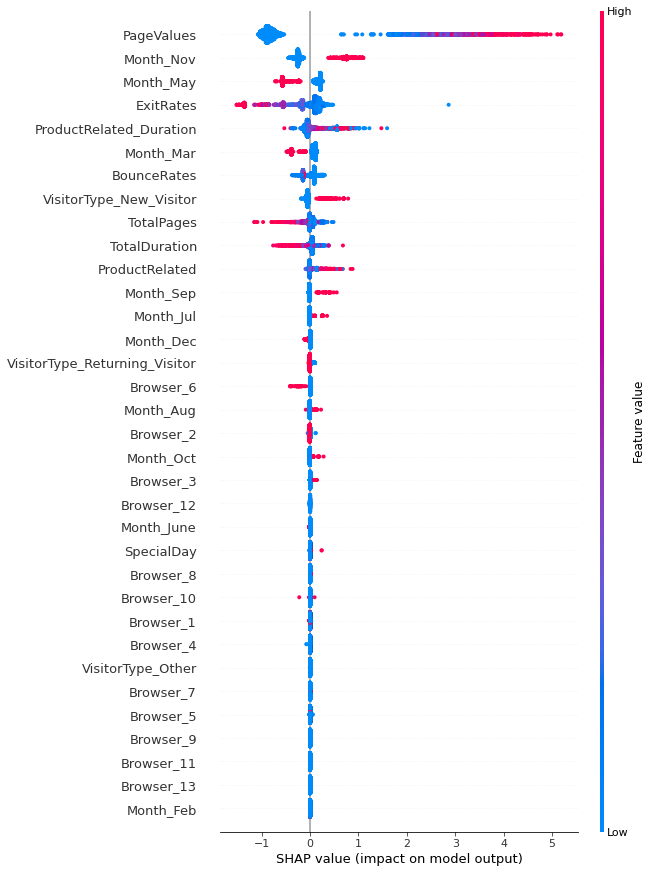

In [13]:
explainer = shap.TreeExplainer(pipeline['classifier'])
processed_test = pd.DataFrame(feature_processing.transform(X_test), columns=new_columns)
shap_values = explainer.shap_values(processed_test)

shap.summary_plot(shap_values, processed_test, max_display=processed_test.shape[1])

На основании полученного графика можно сделать определенные выводы относительно характера зависимости между признаками и целевой переменной. Представим некоторые из них: <br>
- Например, видно, что высокие значения признака `PageValues`, рассчитываемого на основе Google Analytics и учитывающего продажи и количество уникальных просмотров страниц, указывают на высокую вероятность совершения покупки в онлайн-магазине.
- Высоко влияние на целевую переменную оказывают признаки, учитывающие месяц наблюдения. Видно, что посещение магазина в ноябре скорее закончится покупкой, а в мае наоборот. Это можно объяснить тем, что в ноябре часто начинаются распродажи.
- Время, проведенное на страницах, связанных с продуктом, неоднозначно влияет на вероятность совершения покупки. Можно заметить, что чем меньше времени пользователь проводит на таких страницах, тем выше вероятность покупки. Возможно это случаи, когда пользователь совершает покупку импульсивно, или наоборот, изучил всю необходимую информацию заранее и на других сайтах, и зашел на сайт магазина, чтобы просто совершить сделку. Количество посещенных страниц, связанных с продуктом, в этом смысле влияет более предсказуемо - чем больше таких веб-страниц посетил пользователь, тем выше вероятность совершения покупки.
- Чем больше страниц всего посетил пользователь и чем больше времени провел на них, тем меньше вероятность покупки.

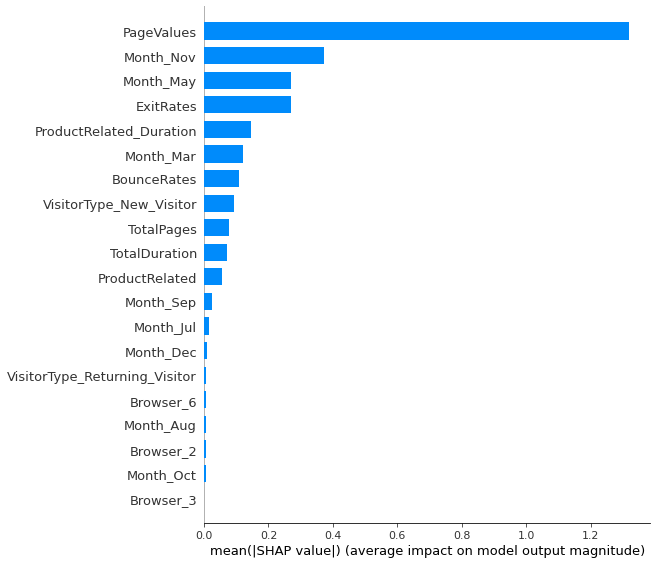

In [14]:
shap.summary_plot(shap_values, processed_test, plot_type="bar")

Не совсем понял, что имелось в виду под "топ 10%", поэтому сделал аналогичный график с важностью признаков для первых 10% наблюдений тестового датасета.

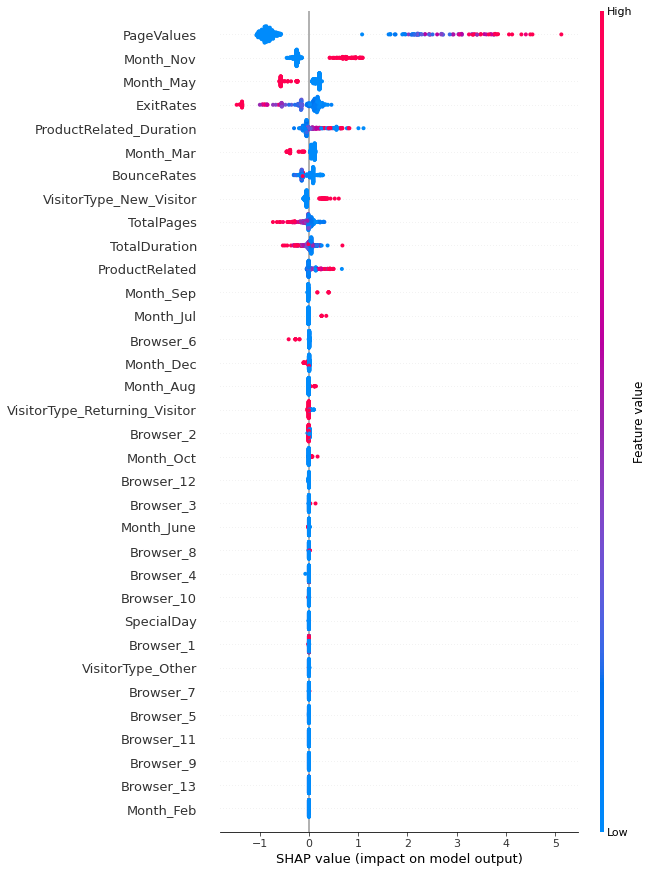

In [15]:
sample = int(processed_test.shape[0] * 0.1)

shap.summary_plot(shap_values[:sample], processed_test.iloc[:sample, :], 
                  max_display=processed_test.shape[1])

6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [16]:
# Первое наблюдение
print(f'Вероятность принадлежности к позитивному классу - {preds[0]}')
shap.force_plot(explainer.expected_value, shap_values[0,:], processed_test.iloc[0,:])

Вероятность принадлежности к позитивному классу - 0.08675511196713176


Наиболее положительно на целевую переменную здесь влияет тот факт, что наблюдение относится к ноябрю, не маю. Этот дает наибольший вклад. Также положительное влиет маленькое значение признака `ExitRates`. В свою очередь `PageValues` равное нулю негативно влияет на вероятность совершения покупки.

In [17]:
# Десятое наблюдение
print(f'Вероятность принадлежности к позитивному классу - {preds[9]}')
shap.force_plot(explainer.expected_value, shap_values[9,:], processed_test.iloc[9,:])

Вероятность принадлежности к позитивному классу - 0.015131404754329602


Это наблюдение относится к маю, что вместе с нулевым показателем признака `PageValues` крайне негативно влияет на целевую переменную. Это сказывается на маленькой предсказанной вероятности совершения покупки. Среди факторов, которые позитивно влияют, в данном случае является тот факт, что это новый пользователь онлайн-магазина.

In [18]:
# Двухсотое наблюдение
print(f'Вероятность принадлежности к позитивному классу - {preds[199]}')
shap.force_plot(explainer.expected_value, shap_values[199,:], processed_test.iloc[199,:])

Вероятность принадлежности к позитивному классу - 0.6769430231737265


Значение признака `PageValues` положительно влияет на целевую переменную. Кроме того данный визит произошел в ноябре, что также позитивно влияет на вероятность совершения покупки. Также положительный вклад вносит количество страниц, связанных с продуктом, которые посетил пользователь, и время, которое он на них провел. Главным негативным фактором выступает общее количество посещенных страниц.